In [1]:
from matplotlib import pyplot as plt
%run "/Users/djpassey/Code/ChaosReservoir/HyperParameterOpt/GenerateExperiments/res_experiment.py"

In [17]:

def remove_percent_edges(A, p):
    return remove_edges(A, floor(p * np.sum(A != 0)))

def net_stat(statf, topo, params, remove_ps, nnets=25, n=2500):
    mean_stats = []
    for p in remove_ps:
        make_net = lambda : remove_percent_edges(generate_adj(topo, params, n=n), p)
        stats = [statf(make_net()) for i in range(nnets)]
        mean_stat = np.mean(stats)
        mean_stats.append(mean_stat)
    return mean_stats

def get_stat(statf, mean_degree, ps=None, n=1000, nnets=20, watts_rewire=.1):
    if ps is None:
        ps = [0, .1, .2, .3, .4, .5, .6, .65, .7, .73, .76, .8, .83, .86, .9, .95]
    stats = []
    for topo in ["geom", "erdos", "random_digraph"]:
        stats.append(net_stat(statf, topo, mean_degree, ps, n=n, nnets=nnets))
        
    if mean_degree == 1:
        stats.append(net_stat(statf, "barab1", None, ps, n=n, nnets=nnets))
    if mean_degree == 2:
        stats.append(net_stat(statf, "barab2", None, ps, n=n, nnets=nnets))
        stats.append(net_stat(statf, "watts2", watts_rewire, ps, n=n, nnets=nnets))
    if mean_degree == 4:
        stats.append(net_stat(statf, "barab4", None, ps, n=n, nnets=nnets))
        stats.append(net_stat(statf, "watts4", watts_rewire, ps, n=n, nnets=nnets))
    return ps, stats

In [18]:
def giant_comp(A, strong=True):
    if strong:
        compf = nx.strongly_connected_components
    else:
        compf = nx.weakly_connected_components
    g = nx.DiGraph(A.T.tolil())
    n = A.shape[0]
    cc = [list(c) for c in compf(g)]
    cc_sz = [len(c) for c in cc]
    return np.max(cc_sz)/n

wcc_comp = lambda x: giant_comp(x, strong=False)

title = "Giant Weak Component"
ylabel = "Percent of nodes in component"

In [19]:
def singletons(A):
    g = nx.DiGraph(A.T.tolil())
    n = A.shape[0]
    cc = [list(c) for c in nx.weakly_connected_components(g)]
    cc_sz = np.array([len(c) for c in cc])
    return np.sum(cc_sz == 1) / n
title = "Singletons (Nodes With Zero Edges)"
ylabel = "Percent of network"

In [20]:
def small_comps(A):
    return 1 - wcc_comp(A) - singletons(A)

title = "Percent of Nodes in Small Components"
ylabel = "Percent of Network"

In [21]:
N = 20
meandegree = 4
ps, gc = get_stat(giant_comp, meandegree, nnets=N, watts_rewire=.1)
ps, singles = get_stat(singletons, meandegree, nnets=N, watts_rewire=.1)
ps, small = get_stat(small_comps, meandegree, nnets=N, watts_rewire=.1)

In [41]:
def compplot(ps, comps, colors):
    for c, col in zip(comps, colors):
        plt.plot(ps, c, c=col, lw=5, alpha=0.8)

In [55]:
colors = np.random.rand(6,3)
colors

array([[0.80878779, 0.36838023, 0.17574264],
       [0.0726492 , 0.59812356, 0.58143624],
       [0.00137357, 0.71762652, 0.18578129],
       [0.67212157, 0.10498033, 0.17252013],
       [0.4677629 , 0.61067972, 0.59582993],
       [0.43361797, 0.72702716, 0.07209421]])

$p_\text{thin}$

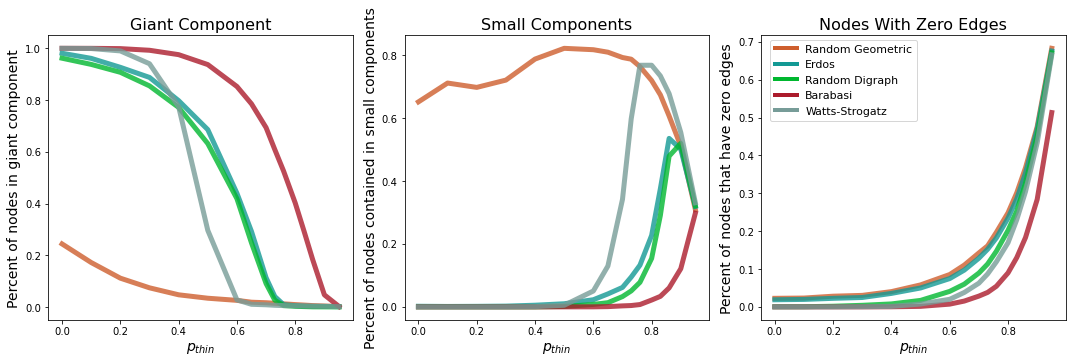

In [70]:
plt.rcParams["figure.figsize"] = [15, 5]
axisfont = 14
titlefont = 16
plt.subplot(1,3,1)
compplot(ps, gc, colors)
plt.title("Giant Component", fontsize=titlefont)
plt.xlabel(r"$p_{thin}$", fontsize=axisfont)
plt.ylabel("Percent of nodes in giant component", fontsize=axisfont)

plt.subplot(1,3,2)
compplot(ps, small, colors)
plt.title("Small Components", fontsize=titlefont)
plt.xlabel(r"$p_{thin}$", fontsize=axisfont)
plt.ylabel("Percent of nodes contained in small components", fontsize=axisfont)

plt.subplot(1,3,3)
compplot(ps, singles, colors)
plt.title("Nodes With Zero Edges", fontsize=titlefont)
plt.xlabel(r"$p_{thin}$", fontsize=axisfont)
plt.ylabel("Percent of nodes that have zero edges", fontsize=axisfont)
names = ["Random Geometric", "Erdos", "Random Digraph", "Barabasi", "Watts-Strogatz"]
for nm, col, sz in zip(names, colors, small):
    plt.plot(ps[0], sz[0], lw=4, label=nm, c=col)
plt.legend(loc=(0.03, .7), fontsize=11)

plt.tight_layout()
plt.savefig("thinningstats.png", dpi=300)
plt.show()

Hyper parameter cube:

Are there parameters where removing increases performance? (Yes)
Does removing edges improve performance in general? (We can't say for sure)

We could pick specific hyper param combos and check different remove-p values, we could run different metrics to compare 

How substantial are the differences in metrics? Maybe our accuracy duration is about the same as valid prediction time in other papers

Does thinning get us to state of the art or does thinning beat state of the art?

Comparing to other results will validate our hyper parameter cube.

For each topology,there is some combination of hyper parameters where thinned out performs non-thinned


Outline:
1. Here is why reservoir computing doesn't work the way you think
    - thinning improves performance
    - spectral radius acts crazy
    - Topology doesn't make a huge difference?
    
    
2. Why?
    - "Steady states"/Linear dependant signals
    - Steepness of tanh
    - Size of the weights corresponding to ss
    - Find hp. where Identity does well
    - Dynamical system analysis with the identity
    - Responsiveness of the system to input data
    
    
3. Hypothesis
   - Check with data